In [1]:
#Get all dependencies
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

# Helper for detecting Interactive vs Commit session-mode
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

# Config
isPretty = True

In [3]:
print('Importing training data...')

X = pd.read_csv('/home/user/CyberSecurity/ieee-fraud-detection/train_transaction.csv')
X_id = pd.read_csv('/home/user/CyberSecurity/ieee-fraud-detection/train_identity.csv')
X = pd.merge(X, X_id, on='TransactionID', how='left')
del X_id

target = 'isFraud'
indexCol = 'TransactionID'
remove_features = [target]
features = [col for col in list(X) if col not in remove_features]
labelEncoders = {}

y = X[target]

print('Done.')

Importing training data...
Done.


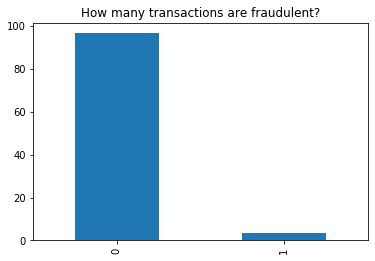

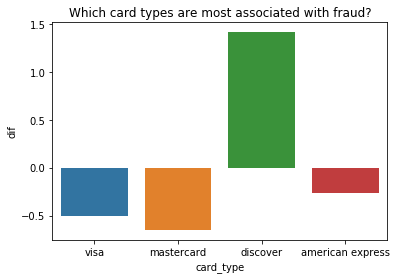

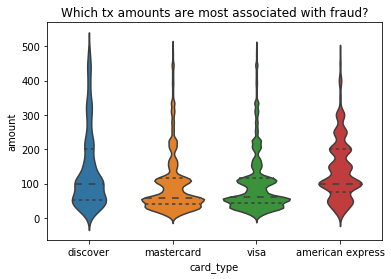

In [4]:
if isPretty:
    fradulentTx = X[X['isFraud'] == 1]
    validTx = X[X['isFraud'] == 0]

    # How many transactions are fraudulent?
    fig, ax = plt.subplots()
    ax = X['isFraud'].value_counts(normalize=True).map(lambda x: x * 100).plot.bar() # % isFraud in training data
    ax.title.set_text('How many transactions are fraudulent?')

    # Which card types are most associated with fraud?
    cardTypeFraud = fradulentTx['card4'].value_counts(normalize=True).map(lambda x: x * 100).to_frame().reset_index()
    cardTypeFraud.columns = ['card_type', 'fraud_freq']
    cardTypeValid = validTx['card4'].value_counts(normalize=True).map(lambda x: x * 100).to_frame().reset_index()
    cardTypeValid.columns = ['card_type', 'valid_freq']
    cardType = pd.merge(cardTypeFraud, cardTypeValid, on='card_type')
    cardType['dif'] = cardType['fraud_freq'] - cardType['valid_freq']
    fig, ax = plt.subplots()
    sns.barplot(x="card_type", y="dif", data=cardType, ax=ax)
    ax.title.set_text('Which card types are most associated with fraud?')

    # Which tx amounts under $500 are most associated with fraud?
    txUnder500 = X[X['TransactionAmt'] < 500][['TransactionAmt', 'card4']]
    txUnder500.columns = ['amount', 'card_type']
    fig, ax = plt.subplots()
    sns.violinplot(x="card_type", y="amount", split=True, inner="quart", data=txUnder500, ax=ax)
    ax.title.set_text('Which tx amounts are most associated with fraud?')

In [6]:
# We'll setup some preprocessing helpers.

def convertLabels(df):
    for col in df.columns:
        if df[col].dtypes == np.object:
            uniques = df[col].unique()
            labelEncoders[col] = preprocessing.LabelEncoder()
            labelEncoders[col].fit(uniques)
            labelEncoderDict = dict(zip(labelEncoders[col].classes_, labelEncoders[col].transform(labelEncoders[col].classes_)))
            df[col] = df[col].apply(lambda x: labelEncoderDict.get(x, '<UNK>'))

def convertToType(dfCol, npType): # Convert to numpy type
    dfCol = dfCol.astype(npType)

def convertToFloat32(df): # Convert numeric data to float32 or int32
    for col in df.columns:
        if df[col].dtypes != np.object and df[col].dtypes != np.int32:
            convertToType(df[col], np.float32)
            
def fillCatNan(df, filler): # Fill missing string values
    for col in df.columns:
        if df[col].dtypes == np.object:
            df[col].fillna(filler, inplace=True)
            
def fillValNan(df, filler): # Fill missing numeric values
    for col in df.columns:
        if df[col].dtypes != np.object:
            df[col].fillna(0.0, inplace=True)
            
def scaleVals(df, target): # Scale values
    for col in df.columns:
        if col != target and col != indexCol and df[col].dtypes != np.object:
            scaler = RobustScaler().fit(df[col].values.reshape(-1, 1))
            df[col] = scaler.transform(df[col].values.reshape(-1, 1))

In [7]:
def preprocess(df):
    convertToType(df[indexCol], np.int32)
    fillCatNan(df ,'<UNK>')
    fillValNan(df , 0.0)
    convertLabels(df)
    scaleVals(df, target)

In [8]:


print('Converting to float32...')

X = X[features] # Only keep feature columns
preprocess(X) # Fill missing values / Reduce memory footprint

print('Done.')

Converting to float32...
Done.


In [9]:
print('Training...')

model = LogisticRegression()
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

# Loop through the splits (only one)
for train_indices, test_indices in splitter.split(X, y):
    # Select the train and validation data
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

    model.fit(X_train, y_train) # Train
    y_pred = model.predict(X_test) # Predict
    print(classification_report(y_test, y_pred)) # Results

Training...


/home/user/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    284939
           1       0.32      0.01      0.02     10331

    accuracy                           0.96    295270
   macro avg       0.64      0.50      0.50    295270
weighted avg       0.94      0.96      0.95    295270



In [13]:
print('Importing testing data...')

P = pd.read_csv('/home/user/CyberSecurity/ieee-fraud-detection/test_transaction.csv')
P_id = pd.read_csv('/home/user/CyberSecurity/ieee-fraud-detection/test_identity.csv')
P = pd.merge(P, P_id, on='TransactionID', how='left')[features]
del P_id

preprocess(P)
#print(P)
print('Done.')

Importing testing data...


MemoryError: 

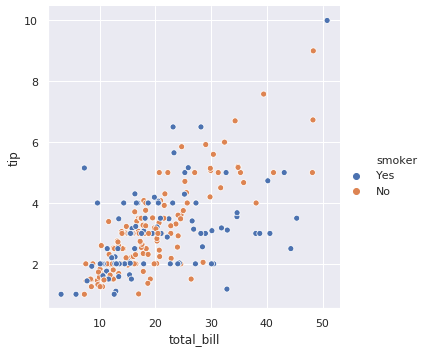

In [6]:
print('Calculating predictions...')

y_pred = []
i, chunksize = 0, 10000
for idx in range(0, len(P), chunksize):
    batch = P[idx:(i+1)*chunksize]
    pred = model.predict_proba(batch) # Predict with probability score
    y_pred += list(pred)
    i += 1

y_pred = np.array(y_pred)
y_pred = np.delete(y_pred, 0, axis=1).flatten() # Only keep probability of isFraud==1

print('Done.')

In [ ]:
print('Saving final output...')

submission = pd.DataFrame({'TransactionID': P['TransactionID'], 'isFraud': y_pred})
submission.to_csv('submission.csv', index=False)
print(submission.head())

del P, y_pred, submission, model

print('Done.')